In [3]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
from tensorflow.keras.utils import Sequence

2023-09-21 13:29:59.582623: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 13:29:59.893478: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 13:29:59.896149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 13:30:02.959833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
image_dir = "../raw_data/train/images"
y_dir = "../raw_data/train/gt"

In [5]:
def process_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize the image to the desired size.
    image_array = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image_array


In [6]:
image_list = []  # To hold the numpy arrays of each image.

for file_name in os.listdir(image_dir):
    if file_name.endswith('.tif') or file_name.endswith('.tiff'):
        file_path = os.path.join(image_dir, file_name)
        try:
            image_array = process_image(file_path)
            image_list.append(image_array)
        except Exception as e:
            print(f"Unable to process {file_path}: {e}")


In [7]:
y_list = []  # To hold the numpy arrays of each reference

for file_name in os.listdir(y_dir):
    if file_name.endswith('.tif') or file_name.endswith('.tiff'):
        file_path = os.path.join(y_dir, file_name)
        try:
            y_array = process_image(file_path)
            y_list.append(y_array)
        except Exception as e:
            print(f"Unable to process {file_path}: {e}")

In [32]:
def calculate_iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # Assuming y_true and y_pred are of shape (batch_size, height, width) and are binary masks
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2]) - intersection
    iou = tf.reduce_mean((intersection + 1e-10) / (union + 1e-10))  # Adding a small epsilon to avoid division by zero
    return iou.numpy() # Convert to numpy array

def calculate_accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total_pixels = tf.reduce_prod(tf.shape(y_true))
    accuracy = correct_pixels / tf.cast(total_pixels, tf.float32)
    
    return accuracy.numpy()

In [8]:
image_tensor = tf.convert_to_tensor(image_list)
ref_tensor   = tf.convert_to_tensor(y_list)
gray_images = tf.image.rgb_to_grayscale(image_tensor)

In [136]:
#baseline
threshold_values = np.linspace(0.4, 0.8, 13)

def plot_accuracy_IoU(gray_images, ref_tensor, threshold_values):
    accuracy_scores = []
    iou_scores = []
    for threshold in threshold_values:
        binary_masks = tf.where(gray_images > threshold, 1.0, 0.0)[:,:,:,-1]
        iou = calculate_iou(ref_tensor, binary_masks)
        accuracy = calculate_accuracy(ref_tensor, binary_masks)
        accuracy_scores.append(accuracy)
        iou_scores.append(iou)
        binary_mask = tf.where(gray_images > 0.55, 1.0, 0.0)[:,:,:,-1]
    sns.lineplot(x=threshold_values,y=accuracy_scores).set(title="Accuracy & IoU for Baseline")
    sns.lineplot(x=threshold_values,y=iou_scores)
    df = pd.DataFrame([threshold_values, np.array(accuracy_scores), np.array(iou_scores)])
    
    return df, binary_mask

/home/arbersejdiji/.pyenv/versions/3.10.6/envs/inria1358/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/arbersejdiji/.pyenv/versions/3.10.6/envs/inria1358/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/arbersejdiji/.pyenv/versions/3.10.6/envs/inria1358/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/arbersejdiji/.pyenv/versions/3.10.6/envs/inria1358/lib/python3.10/site-packages/seaborn

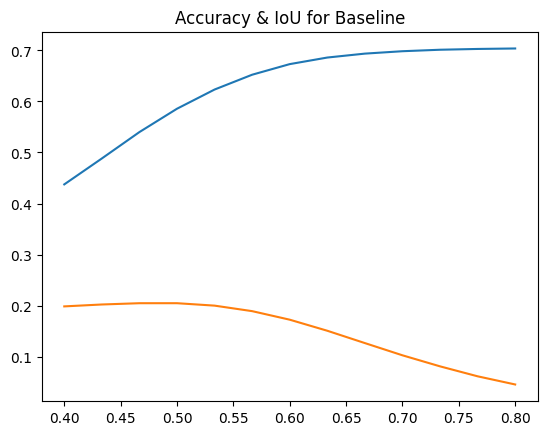

In [139]:
df, binary_mask = plot_accuracy_IoU(gray_images, ref_tensor, threshold_values)

In [140]:
def show_images_baseline(image):
    fig, ax = plt.subplots(1,3, figsize=(20,5))

    # Actual 

    ax[0].imshow(gray_images[image], cmap="gray")
    ax[0].set_title('Actual Picture in Gray Scale')

    # Reference

    ax[1].imshow(ref_tensor[image], cmap="gray")
    ax[1].set_title('Reference Mask')


    # Baseline prediction

    ax[2].imshow(binary_mask[image], cmap="gray")
    ax[2].set_title('Prediction Baseline')


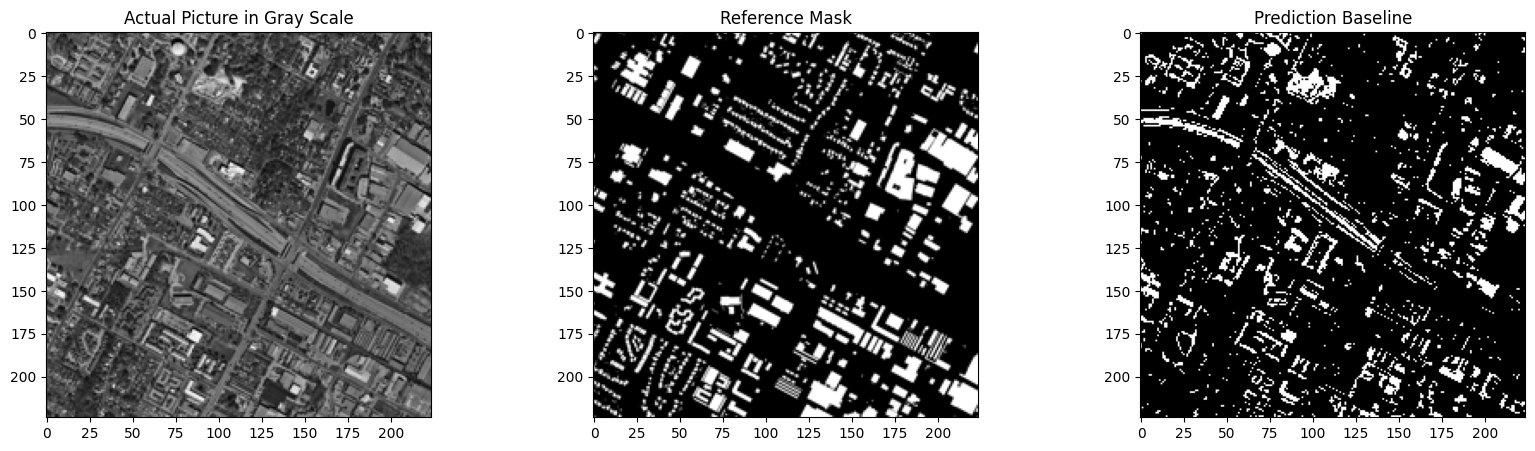

In [141]:
show_images_baseline(7)

In [31]:
from sklearn.cluster import KMeans

# Convert the tensor to numpy array
numpy_images = image_tensor.numpy()

# Reshape the array to 2D for clustering
shape = numpy_images.shape
numpy_images = numpy_images.reshape(-1, 3)

kmeans = KMeans(n_clusters=2)
kmeans.fit(numpy_images)

# Reshape the labels back to image shape
clustered_labels = kmeans.labels_.reshape(shape[:-1])

/home/arbersejdiji/.pyenv/versions/3.10.6/envs/inria1358/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


NameError: name 'calculate_iou' is not defined

In [33]:
iou = calculate_iou(ref_tensor, clustered_labels)
accuracy = calculate_accuracy(ref_tensor, clustered_labels)

In [35]:
accuracy

0.5108838



plt.imshow(clustered_labels[7], cmap="gray")